In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('./Data/HH_rent_clean_wt_dummy.csv')
dataset.head()

,Area,Rent,Rooms_1.5,Rooms_2,Rooms_2.5,Rooms_3,Rooms_3.5,Rooms_4,Rooms_4.5,Rooms_5,...,Location_Hohenfelde,Location_Jenfeld,Location_Niendorf,Location_Othmarschen,Location_Rahlstedt,Location_St. Georg,Location_Stellingen,Location_Uhlenhorst,Location_Wandsbek,Location_Winterhude
0,84.00,1150.00,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,68.17,382.43,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,64.17,483.84,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,49.63,715.00,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,60.25,468.75,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


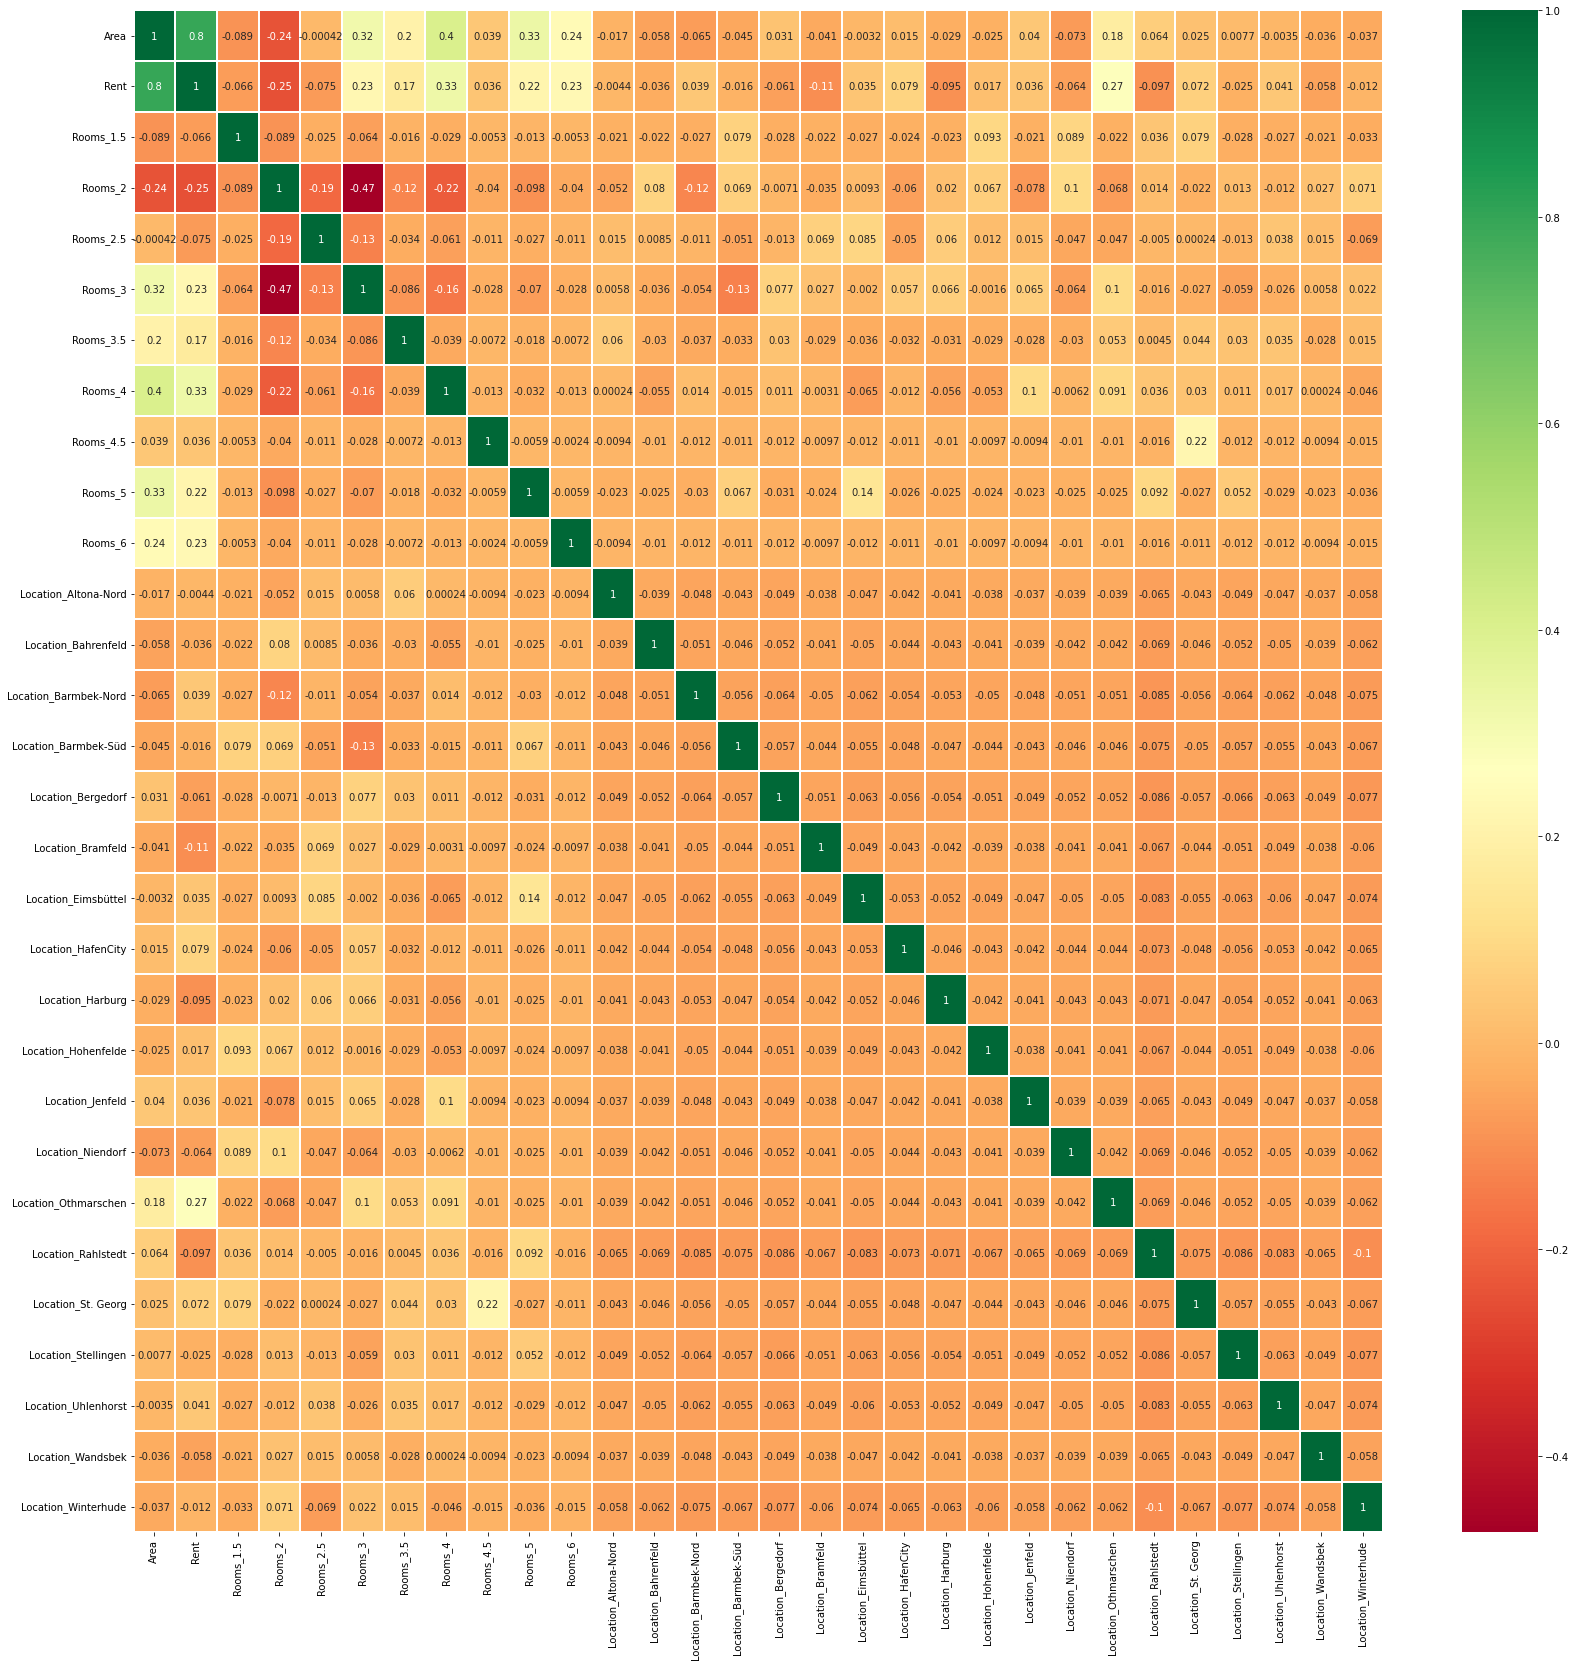

In [3]:
#check the correlation again using new dataframe correlation plot
import seaborn as sns
plt.figure(figsize=(28, 28))
sns.heatmap(dataset.corr(), annot=True,
            linewidth=.2, cmap="RdYlGn")
plt.show();

We have too many features with low correlations: 
We need to select a few to work with 

In [4]:
# creating the correlation matrix
cor = dataset.corr()

# Checking the correlation with our label
cor_target = abs(cor['Rent'])

# Selecting 'highly' correlated features
relevant_features = cor_target[cor_target>0.3]
list(relevant_features.index)

['Area', 'Rent', 'Rooms_4']

In [5]:
df_reduced = dataset[list(relevant_features.index)]
df_reduced.head()

,Area,Rent,Rooms_4
0,84.00,1150.00,0
1,68.17,382.43,0
2,64.17,483.84,0
3,49.63,715.00,0
4,60.25,468.75,0


In [6]:
train_df_reduced = df_reduced.sample(frac=0.8, random_state=0)
test_df_reduced = df_reduced.drop(train_df_reduced.index)

train_features = train_df_reduced.copy()
test_features = test_df_reduced.copy()

train_labels = train_features.pop('Rent')
test_labels = test_features.pop('Rent')

# Making sure that the data is in correct shape and format
print(f'Train features shape = {train_features.shape}')
print(f'Test features shape = {test_features.shape}')
print(f'Train labels shape = {train_labels.shape}')
print(f'Test labels shape = {test_labels.shape}')

Train features shape = (338, 2)
Test features shape = (84, 2)
Train labels shape = (338,)
Test labels shape = (84,)


In [7]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train = scalar.fit_transform(train_features)
X_test = scalar.fit_transform(test_features)

## Building the a simple neural network

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError

In [9]:
model = Sequential(
    [
        Dense(30, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(20, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(10, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        Dense(1, activation = 'linear')
    ], name = "Rent_prediction_HH" 
)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-09-09 10:03:32.035818: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-09 10:03:32.036222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
model.compile(
    loss=MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

In [12]:
from tabnanny import verbose


model.fit(X_train, train_labels, epochs = 1000, verbose=0)

In [13]:
from sklearn.metrics import mean_squared_error
train_pred = model.predict(X_train)
print(f'Test RMSE = {mean_squared_error(train_labels, train_pred ,squared = False)}')

11/11 [==============================] - 0s 3ms/step
Test RMSE = 360.1280008355351


2022-09-09 10:04:55.493077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [14]:
test_pred = model.predict(X_test)
print(f'RMSE = {mean_squared_error(test_labels, test_pred ,squared = False)}')

3/3 [==============================] - 0s 9ms/step
RMSE = 381.727690932622


Text(0, 0.5, 'Rent-predi($in\\;eur$)')

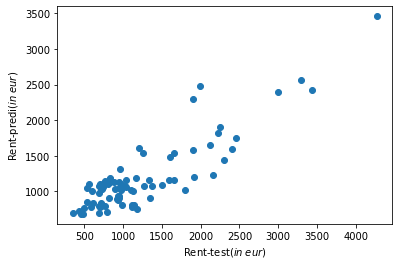

In [15]:
fig4, ax4 = plt.subplots()
ax4.scatter(test_labels, test_pred)
ax4.set_xlabel('Rent-test($in\;eur$)')
ax4.set_ylabel('Rent-predi($in\;eur$)')